## Notebook for TBI ICU NLP 

## Description
### In-hospital mortality is estimated using Natual Language Processing techniques based on Radiologist notes of Head CT scan. The CT is the most common modality for TBI patients in the dataset. Therefore the notes, especially the first CT notes may have predictive value for the mortality. 

### In addition, the incremental value of age and sex is also evaluated.

In [19]:
import numpy as np
import pandas as pd
#import nltk
from nltk import word_tokenize
import string

import scipy
import sklearn.metrics as metrics
import matplotlib.pyplot as plt


In [20]:
def tokenizer_better(text):
    # tokenize the text by replacing punctuation and numbers with spaces and lowercase all words
    punc_list = string.punctuation + '0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.lower().translate(t)
    tokens = word_tokenize(text)
    return tokens


def preprocess_text(df):
    # This function preprocesses the text by filling not a number and replacing new lines ('\n') and carriage returns ('\r')
    df.conclusion = df.conclusion.fillna(' ')
    df['conclusion'] = df['conclusion'].str.replace('\n',' ')
    df['conclusion'] = df['conclusion'].str.replace('\r',' ')
    return df


In [21]:
def train_draw_ROC(model, X_train, X_test, y_train, y_test, axp, title):
    model = model
    y_train_preds = model.predict_proba(X_train)[:,1]
    y_test_preds = model.predict_proba(X_test)[:,1]
    fpr_t, tpr_t, threshold = metrics.roc_curve(y_train, y_train_preds)
    
    roc_auc_t = metrics.auc(fpr_t, tpr_t)
    fpr_v, tpr_v, threshold = metrics.roc_curve(y_test, y_test_preds)
    roc_auc_v = metrics.auc(fpr_v, tpr_v)


    ax = axp or plt.gca()
#    ax.figure(figsize=(6,6))
    ax.set_title(title, fontsize = 12)

    ax.plot(fpr_t, tpr_t, 'b', label = 'AUC train = %0.2f' % roc_auc_t)
    ax.plot(fpr_v, tpr_v, 'g', label = 'AUC test = %0.2f' % roc_auc_v)
    ax.legend(loc = 'lower right')
    ax.plot([0, 1], [0, 1],'r--')
#    ax.axes().set_aspect('equal')
    ax.set_xlim([-0.02, 1.02])
    ax.set_ylim([-0.02, 1.02])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    #return



In [22]:
# read csv including notes, gcs, age,... , and outcome
head_ct_notes = pd.read_csv("text_for_NLP_gcs_age.csv").dropna(subset=['conclusion'])

head_ct_notes.head()

,Unnamed: 0,hadm_id,gender,age,gcs,description,charttime,category,text,hospital_expire_flag,conclusion
0,0,126297,M,66.0,14.0,CT HEAD W/O CONTRAST,2128-09-26 10:10:00,Radiology,[**2128-9-26**] 10:10 AM\n CT HEAD W/O CONTRAS...,0,: Interval minimal reduction of leftward subf...
1,1,138940,F,36.0,15.0,CT HEAD W/O CONTRAST,2117-02-19 16:42:00,Radiology,[**2117-2-19**] 4:42 PM\n CT HEAD W/O CONTRAST...,0,: Little change compared to the recent CT bra...
2,2,138940,F,36.0,15.0,CT HEAD W/O CONTRAST,2117-02-18 22:44:00,Radiology,[**2117-2-18**] 10:44 PM\n CT HEAD W/O CONTRAS...,0,:\n 1. ICP bolt via right frontal approach en...
3,3,138940,F,36.0,15.0,CT HEAD W/O CONTRAST,2117-02-18 11:56:00,Radiology,[**2117-2-18**] 11:56 AM\n CT HEAD W/O CONTRAS...,0,:\n\n 1. Left frontal and temporal lobe subar...
4,4,138940,F,36.0,15.0,CT HEAD W/O CONTRAST,2117-02-21 16:33:00,Radiology,[**2117-2-21**] 4:33 PM\n CT HEAD W/O CONTRAST...,0,:\n Little overall change in appearance of sub...


#### A example of Radiologist CT notes text

In [23]:
print(head_ct_notes.iloc[3].text)

[**2117-2-18**] 11:56 AM
 CT HEAD W/O CONTRAST                                            Clip # [**Clip Number (Radiology) 4287**]
 Reason: eval bleed
 ______________________________________________________________________________
 [**Hospital 2**] MEDICAL CONDITION:
  40 year old woman with hx MVC
 REASON FOR THIS EXAMINATION:
  eval bleed
 No contraindications for IV contrast
 ______________________________________________________________________________
 WET READ: [**Doctor Last Name 787**] [**Doctor First Name 137**] [**2117-2-18**] 1:03 PM
  Sub-arachnoid hemorrhage overlying the left frontal and temporal lobes.  Sub-
  arachnoid hemorrhage versus contusion in right frontal lobe.  Sub-dural
  hematoma over the tentorium cerebelli bilaterally.  Diffuse effacement of the
  sulci, suggestive of cerebral edema, although grey-white differentiation is
  maintained.  Fracture through the posterior aspect of the sphenoid sinus that
  approaches the left cavernous internal carotid canal. 

In [24]:
print("shape of notes DF is:", head_ct_notes.shape, "unique admssions: ", head_ct_notes.hadm_id.nunique())

shape of notes DF is: (489094, 11) unique admssions:  2224


In [25]:
# select the first HEAD CT notes for data cleaning
withidx= head_ct_notes.groupby(['hadm_id']).agg({'charttime':min})
withidx.reset_index(inplace = True)
idx = pd.MultiIndex.from_frame(withidx)

gb = head_ct_notes.groupby(['hadm_id', 'charttime']).agg({'age':'first', 'gcs':'first',
                                                         'conclusion':'first', 'hospital_expire_flag':'first'})

#clean up notes section
df_notes = preprocess_text(gb.loc[idx])

np.random.seed(7)
msk = np.random.rand(len(df_notes)) < 0.8
(X_train, y_train), (X_test, y_test) = \
(df_notes[['gcs','age','conclusion']][msk], df_notes['hospital_expire_flag'][msk]), \
(df_notes[['gcs','age','conclusion']][~msk], df_notes['hospital_expire_flag'][~msk])


In [26]:
# corpus specific stop words
# may be optimized further later
my_stop_words = ["CT", "HEAD", "year", "old", "CONTRAST", "Number", "Radiology",
                  "Number", "Clip", "FINAL","REPORT", "Admitting","Diagnosis", "Hospital","MEDICAL",
                 "MEDICAL","CONDITION", "EXAMINATION", "Last","Name", "Doctor", "FINDING", "FINDINGS",
                  "Reason", "please", "INDICATION","___"]

my_stop_words = [x.lower() for x in my_stop_words]

In [27]:
# fit our vectorizer.
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features = 3000,
                       tokenizer = tokenizer_better,
                       stop_words = my_stop_words)
# this could take a while
vect.fit(X_train['conclusion'].values)

X_train_0 = vect.transform(X_train['conclusion'].values)
X_test_0 = vect.transform(X_test['conclusion'].values)


C:\Data\Anaconda3\envs\Python3ML\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [28]:
# add age to sparse matrix for Logistic regression
import scipy
from scipy.sparse import coo_matrix, hstack

X_train_1 = scipy.sparse.hstack((X_train_0,coo_matrix(X_train['age'][:,None]))).A
X_test_1 = scipy.sparse.hstack((X_test_0,coo_matrix(X_test['age'][:,None]))).A

X_train_2 = scipy.sparse.hstack((X_train_0,coo_matrix(X_train[['gcs','age']]))).A
X_test_2 = scipy.sparse.hstack((X_test_0,coo_matrix(X_test[['gcs','age']]))).A

C:\Data\Anaconda3\envs\Python3ML\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """
C:\Data\Anaconda3\envs\Python3ML\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


## Logistic Regression Grid Search

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = [    
    {'penalty' : ['l1', 'l2',  'none'],
    'C' : np.logspace(-2, 4, 10),
    'solver' : ['lbfgs','newton-cg','liblinear','sag'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

logModel = LogisticRegression()
clf = GridSearchCV(logModel, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)
best_clf = clf.fit(X_train_0,y_train)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 480 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 330 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 822 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 1325 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 1409 out of 1440 | elapsed:   27.7s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   31.2s finished
C:\Data\Anaconda3\envs\Python3ML\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [30]:
best_clf.best_estimator_


LogisticRegression(C=0.046415888336127774, max_iter=2500, solver='sag')

In [31]:
X_train_2.shape

(1780, 3002)

## logistic regression and ROC plot

In [32]:
# logistic regression
from sklearn.linear_model import LogisticRegression
## clf_0=LogisticRegression(C = global_c, penalty = 'l2', random_state = 42)
clf_0 = LogisticRegression(C=best_clf.best_estimator_.C, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=best_clf.best_estimator_.max_iter, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver=best_clf.best_estimator_.solver, tol=best_clf.best_estimator_.tol, 
                           verbose=0,
                   warm_start=False)
clf_1 = LogisticRegression(C=best_clf.best_estimator_.C, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=best_clf.best_estimator_.max_iter, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver=best_clf.best_estimator_.solver, tol=best_clf.best_estimator_.tol, 
                           verbose=0,
                   warm_start=False)
clf_2 = LogisticRegression(C=best_clf.best_estimator_.C, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=best_clf.best_estimator_.max_iter, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver=best_clf.best_estimator_.solver, tol=best_clf.best_estimator_.tol, 
                           verbose=0,
                   warm_start=False)

#clf_0 = best_clf.best_estimator_
clf_0.fit(X_train_0, y_train)

#clf_1 = best_clf.best_estimator_
clf_1.fit(X_train_1, y_train)

#clf_2 = best_clf.best_estimator_
clf_2.fit(X_train_2, y_train)

C:\Data\Anaconda3\envs\Python3ML\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.046415888336127774, max_iter=2500, random_state=42,
                   solver='sag')

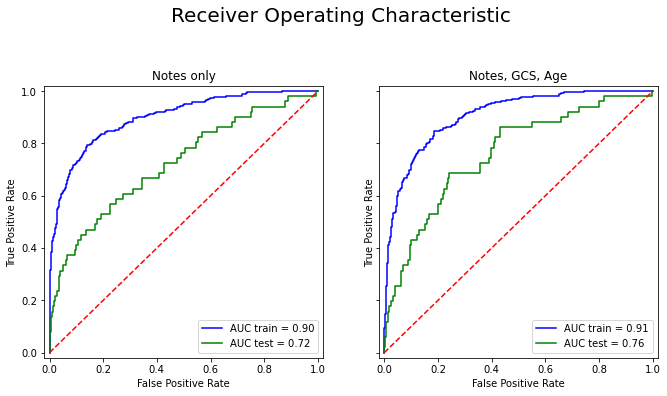

In [33]:
# plot ROC curves

#fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(16, 5))
fig, (ax1, ax3) = plt.subplots(1, 2, sharey=True, figsize=(11, 5))

fig.suptitle('Receiver Operating Characteristic', fontsize = 20, y=1.1)

train_draw_ROC(clf_0, X_train_0, X_test_0, y_train, y_test, ax1, "Notes only" )
#train_draw_ROC(clf_1, X_train_1, X_test_1, y_train, y_test, ax2, "Notes, Age" )
train_draw_ROC(clf_2, X_train_2, X_test_2, y_train, y_test, ax3, "Notes, GCS, Age" )

plt.show()

In [34]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix

predicted_svm = clf_0.predict(X_test_0)
print('Test Accuracy: ', "{:.2%}".format(accuracy_score(predicted_svm, y_test)))
print("")
print(classification_report(y_test, predicted_svm))

Test Accuracy:  89.19%

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       393
           1       0.58      0.22      0.31        51

    accuracy                           0.89       444
   macro avg       0.74      0.60      0.63       444
weighted avg       0.87      0.89      0.87       444

